# GDELT Demo: Classification

Instructions: [README.md](../README.md) in project root.

Starting point for Jupyter notebooks: [/Start_here.ipynb](../Start_here.ipynb) in project root.


This notebook breaks out some of the classification tasks associated with my GDELT analysis. For this initial stage I will address questions like: 

* Can I use various aggregate stats of "relationships" (as actor 1, actor 2, or both) to identify developed versus developing (or high- vs. low-GDP, or high- vs. low-HDI) countries?

## Findings and visualizations

**NOTE**: As with the regression analysis, to allow for execution of these demos without placing multiple gigabytes in the repo, I am engineering them to run with sample data when bigger datasets are unavailable. Thus specific metrics may not agree with what I report.

In [4]:
import sys
import os
import importlib

#project imports
sys.path.insert(0, os.path.join(os.getcwd(), ".."))
import classification
import pandas_gdelt_helper


*****    DECISION TREE    *****

	----- Sanity check 1: simple balance demo -----

	----- What am I missing? -----
The issue is that several items that say they predicted as 'L' show up as 'B'
when I try to follow the graphed tree. What am I missing?


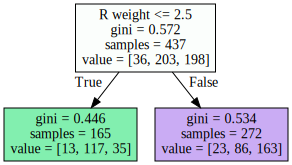

Now considering [[1, 1, 1, 1]]
I predict: ['L']
Now considering [[3, 3, 3, 3]]
I predict: ['R']
Now considering [[4, 4, 3, 3]]
I predict: ['R']
Now considering [[2, 2, 1, 1]]
I predict: ['L']
Now considering [[1, 1, 5, 5]]
I predict: ['R']
Gini score is None


	----- What am I missing? -----
The issue is that several items that say they predicted as 'L' show up as 'B'
when I try to follow the graphed tree. What am I missing?


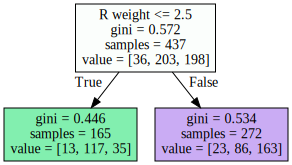

Now considering [[1, 1, 1, 1]]
I predict: ['L']
Now considering [[3, 3, 3, 3]]
I predict: ['R']
Now considering [[4, 4, 3, 3]]
I predict: ['R']
Now considering [[2, 2, 1, 1]]
I predict: ['L']
Now considering [[1, 1, 5, 5]]
I predict: ['R']
Entropy score (i.e. information gain) is None


*****        SVM          *****
Classifier coef for SVM:
[[-0.9090892 ]
 [-0.20512788]
 [ 0.10256559]
 [ 0.41025349]]

*****    RANDOM FOREST    *****
[1. 1.]


In [22]:
importlib.reload(classification)
importlib.reload(pandas_gdelt_helper)

from classification import GdeltClassificationTask as Task
task = Task()
task.do_decision_tree()
task.do_svm()
task.do_random_forest()

### Classification by level of development

For this initial version, just divide the world into developed and developing countries based on GDP.
This classification isn't inherently earthshaking (because we can simply look up GDP and don't need GDELT to predict it) but it's a sort of sanity check that my classification strategies are interesting. More generally, predicting development by the 'signature' in GDELT might tell us something nontrivial about world events.

Features will be things like "number of different relationships," "ratio of actor 1 to actor 2 relationships," specific CAMEO codes (eventcode families) in those relationships, etc., where *relationships* means events linking actor 1 to actor 2.

In [3]:
importlib.reload(classification)
importlib.reload(pandas_gdelt_helper)
from pandas_gdelt_helper import get_country_features, get_country_external
get_country_features()


,name,actor1_relationships,actor2_relationships
code,,,
BOL,Bolivia,1,4
CAN,Canada,12,7
ESP,Spain,5,6
EUR,Europe,9,13
FRA,France,13,15
GBR,United Kingdom,24,18
GHA,Ghana,14,12
ISR,Israel,28,31
ITA,Italy,17,18


### Using classifiers to predict violent events

The sanity check version of this would be whether simply a certain number of violent event codes at time *t-1* back to whatever *t-N* predicts violent events. Violent events will need to be defined based on CAMEO code.

More interestingly, the question would be predicting violence at time *t* through nonviolent patterns at time *t'* < *t*.